## Intensity filtered data using reference aluminium wavelength 309.506 (pixel number 445) using saturated data


In [9]:
import os
from sys import stdout
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import peakutils
import scipy.io
%matplotlib inline 
from math import sqrt
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn import linear_model
from sklearn.linear_model import ElasticNet,ElasticNetCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    mse = []
    component = np.arange(1, n_comp)
    for i in component:
        pls = PLSRegression(n_components=i)
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mse.append(mean_squared_error(y, y_cv))
        comp = 100*(i+1)/40
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
        plt.show()
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    
    return
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
"""   
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted $^{\circ}$Brix')
        plt.ylabel('Measured $^{\circ}$Brix')
        plt.show()
    return
""" 

"   \n    # Fit a line to the CV vs response\n    z = np.polyfit(y, y_c, 1)\n    with plt.style.context(('ggplot')):\n        fig, ax = plt.subplots(figsize=(9, 5))\n        ax.scatter(y_c, y, c='red', edgecolors='k')\n        #Plot the best fit line\n        ax.plot(np.polyval(z,y), y, c='blue', linewidth=1)\n        #Plot the ideal 1:1 line\n        ax.plot(y, y, color='green', linewidth=1)\n        plt.title('$R^{2}$ (CV): '+str(score_cv))\n        plt.xlabel('Predicted $^{\\circ}$Brix')\n        plt.ylabel('Measured $^{\\circ}$Brix')\n        plt.show()\n    return\n"

In [3]:
def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_[:,0]))
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_[:,0]))
    Xc = X[:,sorted_ind]
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

In [4]:
def msc(input_data, reference=None):
    ''' Perform Multiplicative scatter correction'''
    # mean centre correction
    for i in range(input_data.shape[0]):
        input_data[i,:] -= input_data[i,:].mean()
    # Get the reference spectrum. If not given, estimate it from the mean    
    if reference is None:    
        # Calculate mean
        ref = np.mean(input_data, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data    
    data_msc = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_data[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_data[i,:] - fit[0][1]) / fit[0][0] 
    return (data_msc, ref)

In [5]:
def snv(input_data):
  
    # Define a new array and populate it with the corrected data  
    data_snv = np.zeros_like(input_data)
    for i in range(input_data.shape[0]):
        # Apply correction
        data_snv[i,:] = (input_data[i,:] - np.mean(input_data[i,:])) / np.std(input_data[i,:])
    return data_snv

In [6]:
x_df = pd.read_csv('../avg_base_wl_basic_28-02.csv', sep = ',')
values = x_df.values
#wl=x_df.columns.values
#print(wl.shape)

#print(values)
#print(type(values))
print(values.shape)
print(values[1].shape)
print(len(values))
x_df

(34, 3648)
(3648,)
34


,216.330000,216.370000,216.410000,216.450000,216.490000,216.520000,216.560000,216.600000,216.640000,216.680000,...,340.120000,340.150000,340.170000,340.200000,340.230000,340.260000,340.290000,340.320000,340.340000,340.370000
0,-34.080506,-52.856238,-53.531268,-50.722102,-46.480848,-48.353168,-43.511188,-42.930313,-25.964166,-13.178900,...,-103.397082,-27.768753,-23.160893,-9.626787,-19.266555,-49.249992,-57.284947,-42.332194,-19.901689,3.392399
1,-35.618919,-60.499509,-60.724984,-58.526364,-52.552160,-54.819421,-50.428250,-48.202075,-29.373010,-7.262829,...,-65.223663,25.026995,31.068621,53.714197,41.419173,-1.771897,-9.098835,12.655631,38.602063,69.219012
2,-62.382227,-84.498001,-82.950714,-81.565761,-74.436931,-77.430743,-70.423088,-64.868505,-43.506519,-21.451839,...,-93.318483,2.007907,0.898504,30.370624,11.331196,-23.058164,-25.353733,-3.266188,21.531311,46.794898
3,-49.101504,-80.148716,-83.607070,-77.709286,-63.839702,-69.958822,-68.338852,-63.386695,-29.598815,21.239889,...,-42.188972,93.573616,118.603411,177.033714,161.691056,82.310284,56.179137,97.075480,151.791278,221.938668
4,-35.597277,-58.723867,-60.834177,-57.003971,-51.635249,-52.753055,-50.356131,-46.890307,-24.775737,3.372683,...,-72.327183,24.663949,30.693258,61.472081,45.860159,-2.779950,-19.371852,6.021838,38.575199,85.071577
5,-36.534193,-59.580579,-59.810637,-55.192681,-50.080626,-51.567380,-51.542303,-46.489816,-26.755774,-1.753168,...,-85.625283,9.758146,12.955223,40.682918,23.893431,-20.144712,-35.420234,-11.428840,20.462124,59.212916
6,-37.056010,-62.295118,-62.219335,-58.452735,-52.370099,-54.861897,-52.544780,-48.673733,-25.452400,4.840277,...,-76.810026,30.638917,34.893883,73.356474,54.438559,1.259937,-14.633469,12.454864,50.428531,101.901342
7,-36.567012,-60.525560,-61.558858,-60.930587,-51.995660,-56.664018,-52.716117,-49.237293,-25.918533,0.284314,...,-81.835294,26.650759,25.292772,59.780565,40.039979,-9.963122,-25.816141,-0.461396,34.829779,80.718363
8,-36.352760,-66.482287,-70.130211,-67.015686,-56.367065,-60.704904,-57.048680,-55.251739,-29.179874,-1.546280,...,-79.287743,33.481820,49.192359,93.304922,84.044624,24.143615,7.073220,34.408659,76.490304,125.803008
9,-31.922748,-51.175660,-52.985698,-47.869829,-44.266964,-45.152212,-43.333262,-39.709429,-22.070866,0.327345,...,-78.304219,6.692097,4.575283,32.220340,18.928740,-18.095330,-29.613183,-6.082963,18.667277,53.660729


[[216.33]
 [216.37]
 [216.41]
 ...
 [340.32]
 [340.34]
 [340.37]]


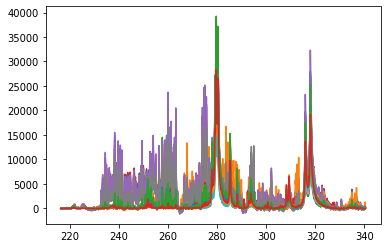

In [10]:
#This is just for visualizing the various plots of the samples

mat = scipy.io.loadmat("../data/H01.mat")
wl= mat["wl"]
print(wl)

for i in range(len(values)):
    plt.plot(wl, values[i])
    #plt.show() #comment this one to have unique plot instead of multiple ones
#range(len(dfs))
#"""




In [12]:
df_y = pd.read_csv('../concentration.csv', sep = ',')
print(type(df_y))
concentration=df_y.values
print(concentration.shape)
#print(concentration)

y_values=df_y.values
y_all=pd.DataFrame(y_values[:,1:-2])
#print(y_all)
df_y

<class 'pandas.core.frame.DataFrame'>
(34, 12)


,Sample,CaO,CaF2,MgO,Al2O3,SiO2,FeO,MnO,Cr2O3,P2O5,V2O5,TiO2
0,H01,37.8,0.18,25.00,9.61,13.20,18.30,1.99,0.20,0.23,0.18,1.03
1,H02,44.5,0.22,18.00,5.04,14.20,18.90,2.10,0.28,0.26,0.06,1.07
2,H03,38.5,0.22,21.10,6.14,10.60,20.20,5.82,0.61,0.40,0.14,0.86
3,H04,38.4,0.04,15.50,4.07,12.80,26.70,3.35,0.52,0.31,0.08,1.07
4,H05,43.2,0.18,17.10,4.14,14.80,21.70,1.72,0.20,0.29,0.18,1.07
5,H06,45.3,0.23,15.90,4.34,16.50,18.90,1.29,0.10,0.30,0.11,1.10
6,H07,46.1,0.25,14.30,4.12,16.20,19.00,1.21,0.09,0.27,0.06,1.08
7,H08,45.1,0.19,13.00,4.05,16.10,21.00,1.26,0.10,0.28,0.06,1.09
8,H09,32.8,0.01,10.60,7.30,14.30,33.20,2.75,0.42,0.32,0.09,1.12
9,H10,42.4,0.24,19.30,6.50,14.70,17.40,2.72,0.31,0.28,0.09,1.06


In [13]:
y_val = concentration[:,3] #1-Si, 2-Fe, 3-Mg, 5-Cu, 6-Mn (4-Zn but too much sparse)
print(y_val)
print(y_val.shape)
y_df= pd.DataFrame(y_val)
#y_df

[25.0 18.0 21.1 15.5 17.1 15.9 14.3 13.0 10.6 19.3 11.2 17.4 7.9 7.9 9.6
 8.9 8.4 10.5 9.1 7.7 6.8 6.1 14.1 11.8 7.2 18.4 19.9 14.9 8.9 8.94 19.9
 14.0 20.0 24.4]
(34,)


# Genetic Algorithm with PLS

In [14]:
import random

import numpy as np
from deap import base
from deap import creator
from deap import tools
from sklearn import datasets
from sklearn import model_selection
from sklearn.cross_decomposition import PLSRegression



In [15]:
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
print(autoscaled_X_train.shape)
print(autoscaled_y_train.shape)

print(np.linalg.matrix_rank(autoscaled_X_train))

(34, 3648)
(34,)
33


In [17]:
# settings
number_of_population = 200
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.01
threshold_of_variable_selection = 0.5

# input
X_train=values
y_train= y_val

#autoscaled_X_train= X_train
#autoscaled_y_train=y_train

autoscaled_X_train= (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
autoscaled_y_train = (y_train - y_train.mean()) / y_train.std(ddof=1)
#print(autoscaled_X_train.shape)
#print(autoscaled_y_train.shape)

#print(np.linalg.matrix_rank(autoscaled_X_train))




# GAPLS
creator.create('FitnessMax', base.Fitness, weights=(1.0,))  # for minimization, set weights as (-1.0,)
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
min_boundary = np.zeros(X_train.shape[1])
max_boundary = np.ones(X_train.shape[1]) * 1.0
#print(min_boundary.shape)
#print(max_boundary.shape)


###this one is for selecting at random the "individual"
def create_ind_uniform(min_boundary, max_boundary):
    index = []
    for min, max in zip(min_boundary, max_boundary):
        index.append(random.uniform(min, max))
    return index


toolbox.register('create_ind', create_ind_uniform, min_boundary, max_boundary)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.create_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)


def evalOneMax(individual):
    individual_array = np.array(individual)
    #individual array is an array of lenght "wl" with values between 0 and 1. 
    #print("individual_array", individual_array.shape)
    
    selected_X_variable_numbers = np.where(individual_array > threshold_of_variable_selection)[0]
    #If an element of ind_arr is bigger than thresh it is kept. this one will be used for the selection of selected_autoscaled_X_train
    #print("selected_X_variable_numbers: ", selected_X_variable_numbers.shape)
    
    selected_autoscaled_X_train = autoscaled_X_train[:, selected_X_variable_numbers]
    #print("selected_autoscaled_X_train: ", selected_autoscaled_X_train.shape)

    
    if len(selected_X_variable_numbers):
        # cross-validation
        #print("np.linalg.matrix_rank(selected_autoscaled_X_train)", np.linalg.matrix_rank(selected_autoscaled_X_train))
        
        #print("AAAA ", min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1, max_number_of_components + 1))
        
        pls_components = np.arange(1, min(min(selected_autoscaled_X_train.shape[0],selected_autoscaled_X_train.shape[1]) + 1,
                                          max_number_of_components + 1), 1)
        #pls_components = np.arange(1, min(np.linalg.matrix_rank(selected_autoscaled_X_train) + 1,
        #                                  max_number_of_components + 1), 1)
        #print("pls components: ", pls_components)
        
        r2_cv_all = []
        
        for pls_component in pls_components:
            
            model_in_cv = PLSRegression(n_components=pls_component)
            
            #print("selected_autoscaled_X_train",selected_autoscaled_X_train)
            
            estimated_y_train_in_cv = np.ndarray.flatten(
                model_selection.cross_val_predict(model_in_cv, selected_autoscaled_X_train, autoscaled_y_train, cv=fold_number))
            
            
            
            estimated_y_train_in_cv = estimated_y_train_in_cv * y_train.std(ddof=1) + y_train.mean()
            r2_cv_all.append(1 - sum((y_train - estimated_y_train_in_cv) ** 2) / sum((y_train - y_train.mean()) ** 2))
        #print(len(r2_cv_all))
        #print("r2_cv_all: ",r2_cv_all)
        """
        try:
            value = np.max(r2_cv_all)
        except ValueError:  #raised if `y` is empty.
            value = -999
            pass
        """
        value = np.max(r2_cv_all)
        
    else:
        value = -999

    return value,


toolbox.register('evaluate', evalOneMax)
toolbox.register('mate', tools.cxTwoPoint)
toolbox.register('mutate', tools.mutFlipBit, indpb=0.05)
toolbox.register('select', tools.selTournament, tournsize=3)

# random.seed(100)
random.seed()
pop = toolbox.population(n=number_of_population)

print('Start of evolution')

fitnesses = list(map(toolbox.evaluate, pop))
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit

print('  Evaluated %i individuals' % len(pop))

for generation in range(number_of_generation):
    print('-- Generation {0} --'.format(generation + 1))

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < probability_of_crossover:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < probability_of_mutation:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    print('  Evaluated %i individuals' % len(invalid_ind))

    pop[:] = offspring
    fits = [ind.fitness.values[0] for ind in pop]

    length = len(pop)
    mean = sum(fits) / length
    sum2 = sum(x * x for x in fits)
    std = abs(sum2 / length - mean ** 2) ** 0.5

    print('  Min %s' % min(fits))
    print('  Max %s' % max(fits))
    print('  Avg %s' % mean)
    print('  Std %s' % std)

print('-- End of (successful) evolution --')

best_individual = tools.selBest(pop, 1)[0]
best_individual_array = np.array(best_individual)
selected_X_variable_numbers = np.where(best_individual_array > threshold_of_variable_selection)[0]
print('Selected variables : %s, %s' % (selected_X_variable_numbers, best_individual.fitness.values))

Start of evolution
  Evaluated 200 individuals
-- Generation 1 --
  Evaluated 108 individuals
  Min 0.6004129400893359
  Max 0.6295014049988966
  Avg 0.6165402083442004
  Std 0.006066009067538594
-- Generation 2 --
  Evaluated 103 individuals
  Min 0.6071298882417828
  Max 0.6335440380115704
  Avg 0.6218436839617464
  Std 0.004756902253680573
-- Generation 3 --
  Evaluated 114 individuals
  Min 0.5391494640962239
  Max 0.6357061324458604
  Avg 0.6248641887045274
  Std 0.007060543931314928
-- Generation 4 --
  Evaluated 111 individuals
  Min 0.6198299043774225
  Max 0.6356798676997724
  Avg 0.6277253475889953
  Std 0.002876583481862477
-- Generation 5 --
  Evaluated 116 individuals
  Min 0.6214710233001488
  Max 0.6389567092207933
  Avg 0.6302927185587995
  Std 0.0031134908740095796
-- Generation 6 --
  Evaluated 122 individuals
  Min 0.561751409903561
  Max 0.6399359995970455
  Avg 0.6323015500532159
  Std 0.005922556714548049
-- Generation 7 --
  Evaluated 112 individuals
  Min 0.6059

  Evaluated 106 individuals
  Min 0.605799770341343
  Max 0.6802358720599316
  Avg 0.6760498448661633
  Std 0.009981807377814251
-- Generation 57 --
  Evaluated 118 individuals
  Min 0.5919372816500541
  Max 0.6802826286442398
  Avg 0.6770484900374264
  Std 0.007991866736416943
-- Generation 58 --
  Evaluated 121 individuals
  Min 0.6375273812526703
  Max 0.6798757358405507
  Avg 0.6771759115231396
  Std 0.005760156166213629
-- Generation 59 --
  Evaluated 106 individuals
  Min 0.5825381214064231
  Max 0.6804021715204756
  Avg 0.6748713878008284
  Std 0.016156278846647144
-- Generation 60 --
  Evaluated 102 individuals
  Min 0.5854625997048819
  Max 0.6801577956562779
  Avg 0.676495605171293
  Std 0.01180759063307344
-- Generation 61 --
  Evaluated 101 individuals
  Min 0.585033326660692
  Max 0.6804256221402087
  Avg 0.6750793027685187
  Std 0.0156819671532688
-- Generation 62 --
  Evaluated 109 individuals
  Min 0.6088216525812885
  Max 0.6803750970522796
  Avg 0.676663078265422
  St

In [24]:
print(selected_X_variable_numbers.shape)

#print(wl[selected_X_variable_numbers].T)

(1482,)


In [25]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [103]:
#X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 348) (27, 1)
(7, 348) (7, 1)
       0
10  11.2
30  19.9
1     18
2   21.1
31    14
33  24.4
16   8.4


37% completed
Suggested number of components:  2



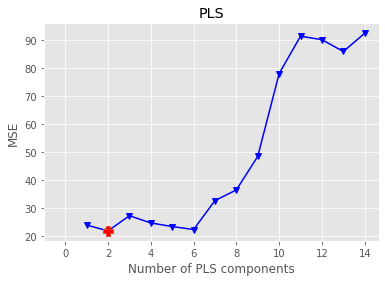

R2 calib: 0.349
R2 CV: 0.101
MSE calib: 15.815
MSE CV: 21.849


In [104]:
optimise_pls_cv(X_train, y_train, 15, plot_components=True) 

R2_pred:  -0.21723812451814561
RMSE:  5.853037599641421



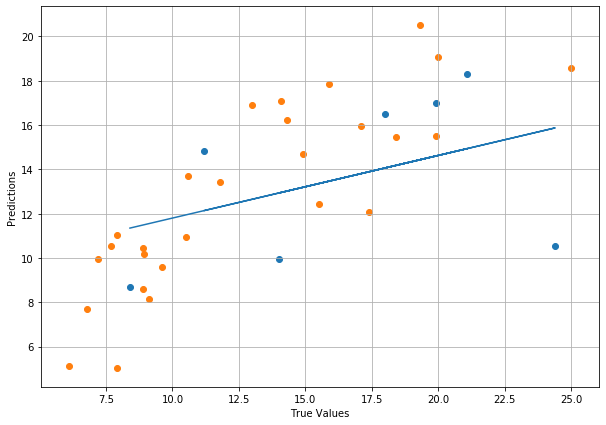

In [106]:
# Define PLS object
pls = PLSRegression(n_components=6)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

In [83]:
def _calculate_vips(model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

In [90]:
a= _calculate_vips(pls)
print(a)

[0.94643694 0.86588004 0.98075252 ... 1.71563019 1.69201276 1.6333998 ]


In [91]:
selected_X_variable_numbers = np.where(b > 1.21)

In [99]:
b=[]
for i in range(len(a)):
    if a[i]> 1.21:
        b.append(i)

In [101]:
len(b)
b

[13,
 14,
 36,
 37,
 40,
 48,
 73,
 77,
 78,
 79,
 81,
 83,
 84,
 85,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 110,
 111,
 112,
 120,
 121,
 124,
 125,
 142,
 540,
 541,
 542,
 551,
 552,
 553,
 554,
 555,
 556,
 557,
 558,
 559,
 560,
 573,
 574,
 575,
 576,
 577,
 578,
 584,
 585,
 586,
 587,
 588,
 691,
 692,
 693,
 694,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 704,
 705,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713,
 714,
 715,
 716,
 717,
 718,
 719,
 720,
 721,
 722,
 723,
 724,
 725,
 726,
 727,
 728,
 729,
 730,
 731,
 732,
 733,
 734,
 735,
 736,
 737,
 738,
 739,
 740,
 741,
 742,
 743,
 744,
 745,
 746,
 747,
 748,
 749,
 750,
 751,
 752,
 753,
 754,
 755,
 756,
 757,
 758,
 759,
 760,
 761,
 762,
 763,
 764,
 765,
 766,
 767,
 768,
 769,
 770,
 771,
 772,
 773,
 774,
 775,
 776,
 777,
 778,
 779,
 783,
 784,
 785,
 786,
 787,
 788,
 789,
 790,
 791,
 799,
 800,
 810,
 811,
 814,
 815,
 816,
 820,
 821,
 822,
 823,
 824,
 825,
 826,
 827,
 828,
 829,
 839,
 843,
 

In [102]:
x_selecta = pd.DataFrame(x_df.values[:,b])
print(x_selecta.shape)

(34, 348)


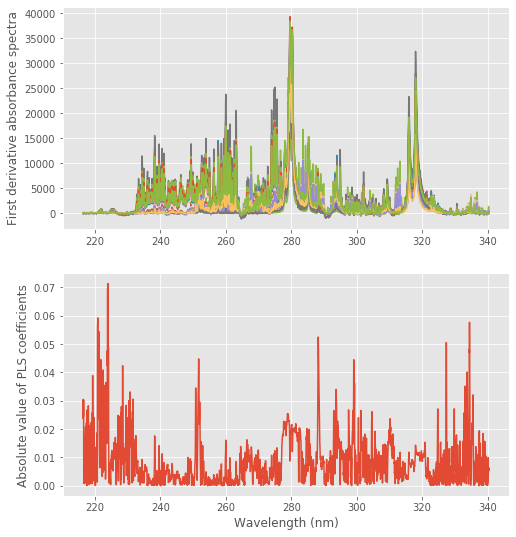

In [109]:
# Define the PLS regression object
pls = PLSRegression(n_components=8)
# Fit data
pls.fit(X_train, y_train)
# Plot spectra
plt.figure(figsize=(8,9))
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X_train.T)
    plt.ylabel('First derivative absorbance spectra')
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_[:,0])) ###this is the interesting line!!!
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
    plt.show()

In [30]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_selecta.values, y_val, 15)
#opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  3
Wavelengths to be discarded  1095
Optimised MSEP  7.710683096305181

--- 388.7665629386902 seconds ---


sorted wavelengths:  [[221.05 233.12 265.37 264.34 260.47 265.84 255.88 240.49 263.48 240.67]]


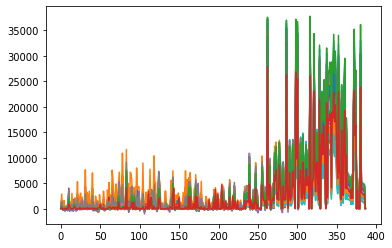

In [31]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [35]:
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 387) (27, 1)
(7, 387) (7, 1)
       0
15   8.9
32    20
6   14.3
2   21.1
17  10.5
13   7.9
21   6.1


50% completed
Suggested number of components:  2



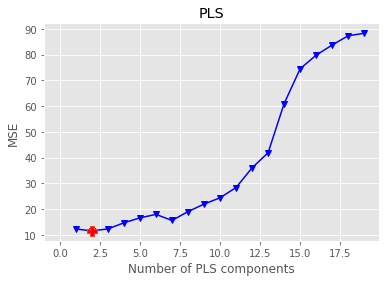

R2 calib: 0.695
R2 CV: 0.564
MSE calib: 8.099
MSE CV: 11.555


In [36]:
optimise_pls_cv(X_train,y_train, 20, plot_components=True)

R2_pred:  0.7720050740759926
RMSE:  2.6295224204452707



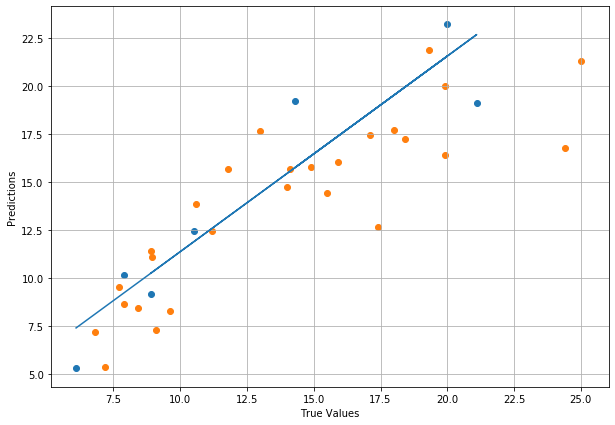

In [40]:
# Define PLS object
pls = PLSRegression(n_components=3)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

Best ones so far:

#1
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.3
threshold_of_variable_selection = 0.6


#2
number_of_population = 150
number_of_generation = 100
max_number_of_components = 10
fold_number = 5
probability_of_crossover = 0.5
probability_of_mutation = 0.25
threshold_of_variable_selection = 0.5


In [120]:
x_df.shape

(24, 1446)

In [121]:
x_selecta = pd.DataFrame(x_df.values[:,selected_X_variable_numbers])

In [122]:
selected_X_variable_numbers.shape

(87,)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(27, 3648) (27, 1)
(7, 3648) (7, 1)
       0
3   15.5
23  11.8
26  19.9
11  17.4
10  11.2
30  19.9
27  14.9


# Principal Components Analysis

In [11]:
n_components=20


x = x_df.values
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

principalComponents = pca.fit_transform(X_std)
print(principalComponents.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))
#print(pca.singular_values_)

(24, 1446)
(1446,)
24
(24, 20)
[32.16 58.34 69.76 79.23 85.78 89.43 91.66 93.69 95.11 96.32 97.1  97.7
 98.23 98.57 98.83 99.08 99.28 99.46 99.61 99.75]


In [12]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(principalComponents, y_df)
# Calibration
y_c = regr.predict(principalComponents)
# Cross-validation
y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_df, y_c)
score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation

mse_c = mean_squared_error(y_df, y_c)
mse_cv = mean_squared_error(y_df, y_cv)

print(score_c, score_cv)
print(mse_c, mse_cv)

0.9848340523115449 -15.14649505941636
0.020707936081303502 22.046798162306988


now using PCA with Linear regression and PLS

In [90]:
n_components=25

x = X_train
x_t = X_test
print(x.shape)
print(x[1].shape)
print(len(x))


# This has to be used later for regression, PCA is done on X only
"""
y_df = pd.read_csv('labels_aligned+.csv', sep = ',')
concentration=y_df.values
#print(concentration)
multi_y = concentration[:,2:]
#print (multi_y)
print (multi_y.shape)
multi_y= np.array(multi_y, dtype=np.float)
y=np.around(multi_y, decimals=4)
#print(y)
"""

# PCA

X_std = StandardScaler().fit_transform(x)
X_std_test = StandardScaler().fit_transform(x_t)
#print(X_std)

pca = PCA(n_components= n_components)
PC=pca.fit(X_std)

x_pc = pca.fit_transform(X_std)
x_test1 = pca.transform(X_std_test)
print(x_pc.shape)
#principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])
#print(principalDf)


#print(pca.explained_variance_ratio_)
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100))

(19, 29)
(29,)
19


ValueError: n_components=25 must be between 0 and min(n_samples, n_features)=19 with svd_solver='full'

In [91]:
regr = linear_model.LinearRegression()
# Fit
regr.fit(x_pc, y_train)
# Calibration
y_p = regr.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_p)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_p)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.5193224597834807
MSE:  1.2581312388016068


37% completed
Suggested number of components:  2



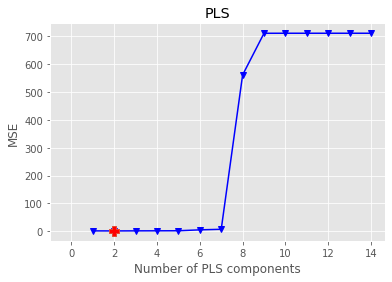

R2 calib: 0.969
R2 CV: 0.099
MSE calib: 0.030
MSE CV: 0.872


In [94]:
optimise_pls_cv(x_pc, y_train, 15, plot_components=True) 

In [100]:
pls = PLSRegression(n_components=2)
# Fit
pls.fit(x_pc, y_train)
# Calibration
y_c = pls.predict(x_test1)
# Cross-validation
#y_cv = cross_val_predict(regr, principalComponents, y_df, cv=10)
# Calculate scores for calibration and cross-validation
score_c = r2_score(y_test, y_c)
#score_cv = r2_score(y_df, y_cv)
# Calculate mean square error for calibration and cross validation
mse_c = mean_squared_error(y_test, y_c)
#mse_cv = mean_squared_error(y_df, y_cv)

print("R2_pred: ", score_c)
print("MSE: ", mse_c)

R2_pred:  0.5193224597834794
MSE:  1.2581312388016104


# Partial Least Square Regression

In [23]:
print(wl.shape)

(1446,)


## Wavelenght selection for PLS

In [10]:
start_time = time.time()

opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(x_df.values, y_val, 15)

print("--- %s seconds ---" % (time.time() - start_time))

100% completed
Optimised number of PLS components:  8
Wavelengths to be discarded  1411
Optimised MSEP  0.39322839374148005

--- 341.1094193458557 seconds ---


sorted wavelengths:  [309.506  399.4131 382.791  291.0649 377.5265 383.387  334.0345 275.32
 333.6584 383.9826]


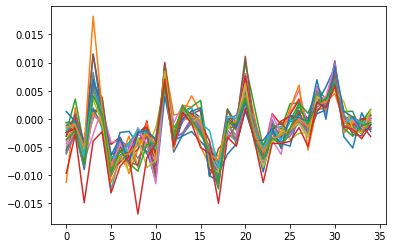

In [11]:
#print(opt_Xc.shape,"\n")
#print("sorted indexes: ", sorted_ind)
print("sorted wavelengths: ", wl[sorted_ind[:10]].T)

plt.plot(opt_Xc.T)
plt.show()

In [124]:
X_train, X_test, y_train, y_test = train_test_split(x_selecta, y_df, test_size=0.2, random_state = 3) #seed for Mg = 3, 16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Si = 7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 16) #seed for Cu =16
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 7) #seed for Fe =7
#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2, random_state = 3) #seed for Mn = 3

#X_train, X_test, y_train, y_test = train_test_split(opt_Xc, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
print(y_test)

(19, 87) (19, 1)
(5, 87) (5, 1)
       0
22  1.11
12  0.32
17  0.39
15  4.54
14  0.77


100% completed
Suggested number of components:  1



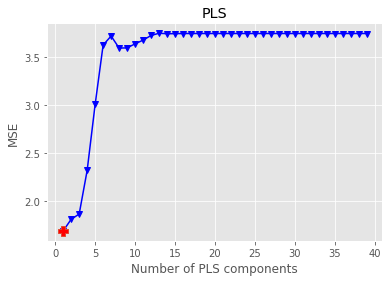

R2 calib: 0.207
R2 CV: -0.638
MSE calib: 0.819
MSE CV: 1.690


In [125]:
optimise_pls_cv(X_train,y_train, 40, plot_components=True)

R2_pred:  -0.5019501966917148
RMSE:  1.9395877766841056



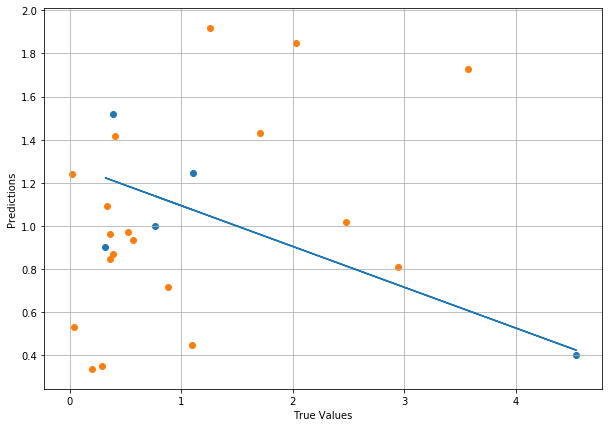

In [128]:
# Define PLS object
pls = PLSRegression(n_components=1)
# Fit
pls.fit(X_train, y_train)

y_pred = pls.predict(X_test)
y_pred1 = pls.predict(X_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Normalization

In [51]:
Xn_train = normalize(X_train, axis=1)
Xn_test = normalize(X_test, axis=1)
print(Xn_train.shape)
print(Xn_test.shape)

(27, 1482)
(7, 1482)


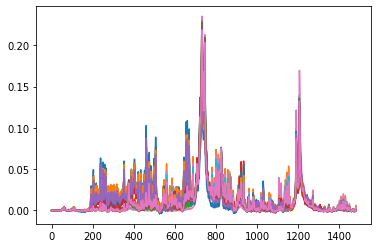

In [52]:
plt.plot(Xn_train.T)
plt.show()

In [53]:
#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xn_train,y_train, 7, plot_components=True)

R2_pred:  0.4893531975724058
RMSE:  3.419987266465691

TEST
 [real, predictions]
[[14.1 18.90831189345998]
 [14.0 17.161365035819625]
 [8.9 9.418279618958724]
 [21.1 16.242784915698614]
 [8.4 7.5474613340348]
 [8.9 13.773935811563382]
 [19.3 19.945657458891404]]



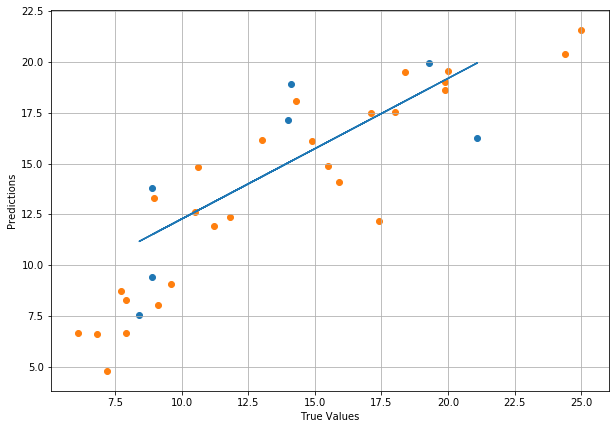

In [55]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(Xn_train, y_train)

y_pred = pls.predict(Xn_test)
y_pred1 = pls.predict(Xn_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using SNV

In [56]:
Xs_train = snv(X_train)
Xs_test = snv(X_test)
print(Xs_train.shape)
print(Xs_test.shape)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xs_train,y_train, 7, plot_components=True)

TypeError: '(0, slice(None, None, None))' is an invalid key

In [134]:
plt.plot(Xs_train.T)
plt.show()

NameError: name 'Xs_train' is not defined

In [135]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xs_train, y_train)

y_pred = pls.predict(Xs_test)
y_pred1 = pls.predict(Xs_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")


b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

NameError: name 'Xs_train' is not defined

## Using Max-norm

In [69]:
Xm_train = X_train / np.max(X_train,axis=0)
Xm_test = X_test / np.max(X_test,axis=0)

#optimise_pls_cv(Xn_train,y_train, 40, plot_components=True)
#optimise_pls_cv(Xm_train,y_train, 15, plot_components=True)

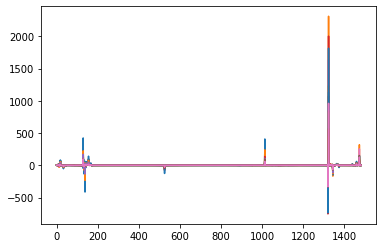

In [70]:
plt.plot(Xm_train.T)
plt.show()

R2_pred:  -64.46537694661592
RMSE:  38.72309102876129

TEST
 [real, predictions]
[[14.1 0.8301553500103029]
 [14.0 23.82754995825756]
 [8.9 -42.45469176187722]
 [21.1 -7.196953938968948]
 [8.4 -10.858422631102878]
 [8.9 7.037827486741614]
 [19.3 -60.7705841095615]]



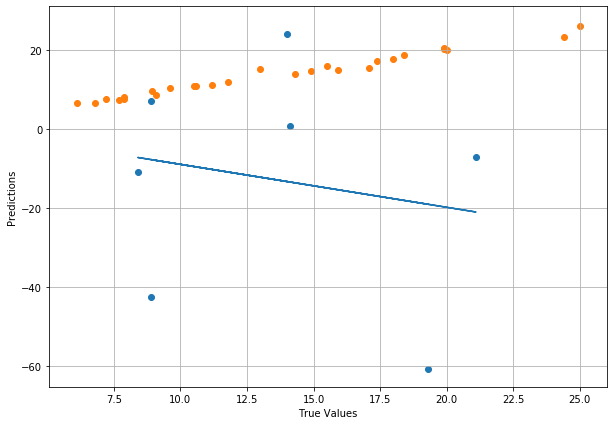

In [71]:
# Define PLS object
pls = PLSRegression(n_components=14)
# Fit
pls.fit(Xm_train, y_train)

y_pred = pls.predict(Xm_test)
y_pred1 = pls.predict(Xm_train)

# Calculate score and error
r2 = r2_score(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))


print("R2_pred: ", r2)
print("RMSE: ", rmse)
#print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("TEST\n [real, predictions]")
print(b)
print("")

c=np.append(y_train, y_pred1, axis=1)

#print("TRAIN\n [real, predictions]")
#print(c)

plt.figure(figsize=(10,7))
plt.scatter(y_test, y_pred)
plt.scatter(y_train, y_pred1)
plt.plot( y_test, linear_model.LinearRegression().fit(y_test, y_pred).predict(y_test) )
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

## Using Savgol filter

In [45]:
X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1446) (19, 1)
(5, 1446) (5, 1)


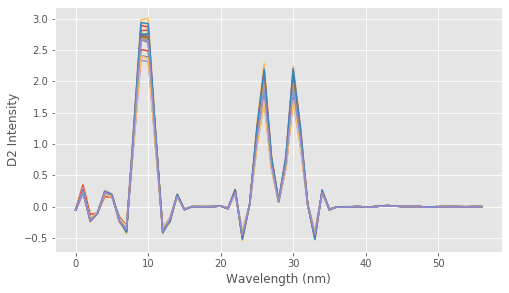

100% completed
Suggested number of components:  8



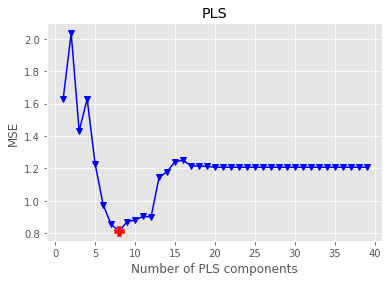

R2 calib: 0.956
R2 CV: 0.404
MSE calib: 0.060
MSE CV: 0.813


In [41]:
# Calculate second derivative
X2 = savgol_filter(opt_Xc, 11, polyorder = 6,deriv=0) # Is this useful with LIBS spectra???
# Plot second derivative
plt.figure(figsize=(8,4.5))
with plt.style.context(('ggplot')):
    plt.plot(range(len(X2.T)), X2.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Intensity')
    plt.show()
    

    
optimise_pls_cv(X2, y_df, 40, plot_components=True)

100% completed
Suggested number of components:  1



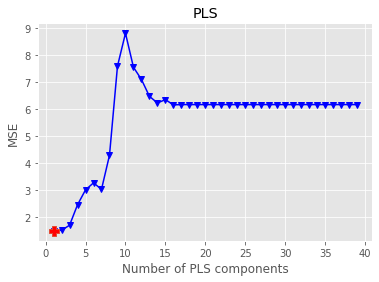

R2 calib: 0.169
R2 CV: -0.027
MSE calib: 1.211
MSE CV: 1.497


In [42]:
X2_train = savgol_filter(X_train, 37, polyorder = 4,deriv=1) 
X2_test = savgol_filter(X_test, 35, polyorder = 4,deriv=1) 




optimise_pls_cv(X2_train, y_train, 40, plot_components=True)

R2_pred:  -2586.547461785336
R2_cv:  -0.690675692387712

[real, predictions]
[[ 3.90000000e-01 -4.48737877e+01]
 [ 2.93000000e-01 -4.61390595e+01]
 [ 2.50000000e-02 -3.88958047e+01]
 [ 2.48000000e+00 -4.94609327e+01]
 [ 3.20000000e-01 -4.45219137e+01]]


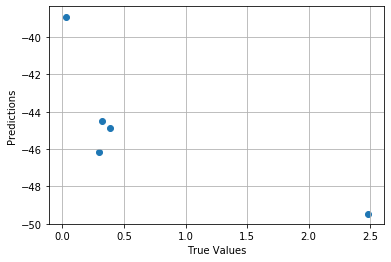

In [43]:
# Define PLS object
pls = PLSRegression(n_components=4)
# Fit
pls.fit(X2_train, y_train)

y_pred = pls.predict(X2_test)

# Cross-validation
y_cv = cross_val_predict(pls, X2_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print("R2_pred: ", score_pred)
print("R2_cv: ",score_cv)
print("")

b=np.append(y_test, y_pred, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Elastic Net

In [72]:
alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

In [73]:
for a in alphas:
    model = ElasticNet(alpha=a).fit(X_train,y_train)   
    score = model.score(X_train, y_train)
    pred_y = model.predict(X_test)
    mse = mean_squared_error(y_test, pred_y)   
    print("Alpha:{0:.4f}, R2:{1:.2f}, MSE:{2:.2f}, RMSE:{3:.2f}".format(a, score, mse, np.sqrt(mse)))

Alpha:0.0001, R2:1.00, MSE:33.17, RMSE:5.76
Alpha:0.0010, R2:1.00, MSE:33.05, RMSE:5.75
Alpha:0.0100, R2:1.00, MSE:32.83, RMSE:5.73
Alpha:0.1000, R2:1.00, MSE:35.80, RMSE:5.98
Alpha:0.3000, R2:1.00, MSE:39.47, RMSE:6.28
Alpha:0.5000, R2:1.00, MSE:41.57, RMSE:6.45
Alpha:0.7000, R2:1.00, MSE:41.85, RMSE:6.47
Alpha:1.0000, R2:1.00, MSE:41.13, RMSE:6.41


In [74]:
model = ElasticNet(alpha=0.0001).fit(X_train,y_train)   
score = model.score(X_train, y_train)
print("Train score: ", score)
pred_y = model.predict(X_test)


rmse = sqrt(mean_squared_error(y_test, pred_y))
r2 = r2_score(y_test, pred_y)
print("RMSE: ", rmse)
print("R^2: ", r2)

Train score:  0.9999768383309343
RMSE:  5.759070542511677
R^2:  -0.44802625066170787


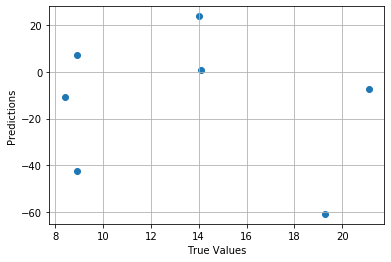

In [75]:
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Random Forest

In [24]:
#X_train, X_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.15)
X_train, X_test, y_train, y_test = train_test_split(principalComponents, y_df, test_size=0.15)


print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(y_test)

(20, 20) (20, 1)
(4, 20) (4, 1)


In [76]:
y_test=np.ravel(y_test)
print(y_test.shape)
y_train=np.ravel(y_train)
print(y_train.shape)

(7,)
(27,)


RMSE:  3.2004078262978712
R^2:  0.5528200879619326 

[real, predictions]
[[14.1 15.032080000000029]
 [14.0 16.45600000000004]
 [8.9 9.520960000000006]
 [21.1 16.531200000000013]
 [8.4 8.7544]
 [8.9 15.052880000000046]
 [19.3 16.943200000000015]]


Text(0, 0.5, 'Predictions')

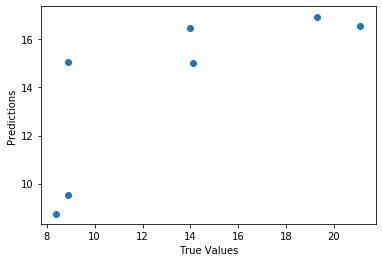

In [78]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 250, max_depth=30, random_state = 42)
# Train the model on training data

rf.fit(X_train, y_train);

# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
print("RMSE: ", rmse)
print("R^2: ", r2, "\n")

y_test= y_test.reshape((len(y_test), 1))
predictions=predictions.reshape((len(y_test), 1))
#print((y_test, predictions))

b=np.append(y_test, predictions, axis=1)

print("[real, predictions]")
print(b)

plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# MultiOutput Random Forest

In [132]:
multi_y = concentration[:,1:-2]
print (multi_y.shape)
print (type(multi_y))
df_y= pd.DataFrame(multi_y)
print (type(df_y))

(24, 6)
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [153]:
X_train, X_test, y_train, y_test = train_test_split(x_df, df_y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)
#print(X_test)

(19, 1130) (19, 6)
(5, 1130) (5, 6)


In [134]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

max_depth = 30
regr_multirf = MultiOutputRegressor(RandomForestRegressor(n_estimators=650,
                                                          max_depth=max_depth,
                                                          random_state=0))
regr_multirf.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     criterion='mse',
                                                     max_depth=30,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
                                                     n_estimators=650,
                                                

In [135]:
y_multirf = regr_multirf.predict(X_test)

In [136]:
print(y_test.shape)
print(y_multirf.shape)

(5, 6)
(5, 6)


In [137]:
rmse = sqrt(mean_squared_error(y_test, y_multirf))
r2 = r2_score(y_test, y_multirf)

print("R^2: ", r2)
print("RMSE: ", rmse)

R^2:  -1.2798201186343863
RMSE:  1.5231794557929577


In [138]:
b=np.append(np.around(y_test,3), np.around(y_multirf,3), axis=1)

print("[real, predictions]")
print(b)

[real, predictions]
[[6.160e+00 0.000e+00 3.630e-01 0.000e+00 6.000e-03 2.060e-01 8.711e+00
  2.880e-01 4.460e-01 2.870e-01 7.790e-01 1.910e-01]
 [6.120e+00 0.000e+00 3.200e-01 0.000e+00 5.000e-03 1.600e-02 8.009e+00
  2.150e-01 4.630e-01 8.500e-02 1.110e-01 1.440e-01]
 [1.253e+01 3.100e-01 2.500e-02 5.000e-02 5.600e-02 3.300e-02 7.822e+00
  2.570e-01 2.970e-01 1.650e-01 1.750e-01 2.170e-01]
 [1.800e-01 5.000e-01 1.110e+00 5.200e-02 1.500e-01 1.260e+00 4.830e-01
  3.630e-01 1.233e+00 2.260e-01 1.360e-01 9.710e-01]
 [1.290e+01 1.200e-01 5.200e-01 1.550e-01 5.200e-01 2.860e-01 6.898e+00
  3.360e-01 7.140e-01 1.420e-01 5.610e-01 2.290e-01]]


Text(0, 0.5, 'Predictions')

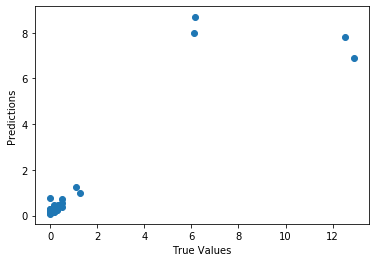

In [139]:
plt.scatter(y_test, y_multirf)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
y_pred=np.around(y_multirf,2)
y_pred[:,0]

array([8.71, 8.01, 7.82, 0.48, 6.9 ])

In [142]:
y_test[0].values

array([ 6.16,  6.12, 12.53,  0.18, 12.9 ])

In [143]:
print("real: ", y_test[0].values)
print("pred: ", y_pred[:,0])

real:  [ 6.16  6.12 12.53  0.18 12.9 ]
pred:  [8.71 8.01 7.82 0.48 6.9 ]


# PLS-2

100% completed
Suggested number of components:  33



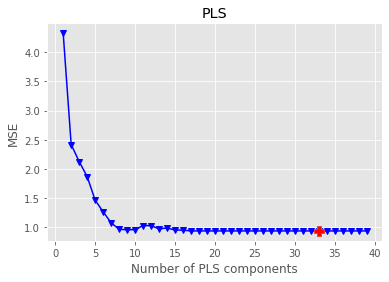

R2 calib: 1.000
R2 CV: 0.018
MSE calib: 0.000
MSE CV: 0.939


In [154]:
optimise_pls_cv(X_train, y_train, 40, plot_components=True)

In [155]:
# Define PLS object
pls = PLSRegression(n_components= 26)
# Fit
pls.fit(X_train, y_train)
# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)
# Calculate scores
score = r2_score(y_train, y_cv)
mse = mean_squared_error(y_train, y_cv)

print("R^2: ", score)
print("MSE: ", mse)

R^2:  0.018347253779067135
MSE:  0.9391318844120397


In [150]:
y_pred = pls.predict(X_test)

# Cross-validation
y_cv = cross_val_predict(pls, X_train, y_train, cv=10)

# Calculate scores for calibration and cross-validation
score_pred = r2_score(y_test, y_pred)
score_cv = r2_score(y_train, y_cv)

print(score_pred) #NAMMERDA
print(score_cv)

-4.070272705754876
0.36555579763038115


In [151]:
pd.DataFrame(np.round(y_pred, decimals=2))

,0,1,2,3,4,5
0,7.84,0.22,0.54,0.19,0.57,0.27
1,8.62,0.12,0.35,0.06,-0.12,-0.06
2,10.50,0.13,-0.61,0.45,0.15,-0.03
3,-0.28,0.42,1.56,-0.11,-0.34,0.95
4,9.93,0.09,0.29,-0.26,0.65,0.14


In [152]:
np.round(y_test, decimals=2)

,0,1,2,3,4,5
20,6.16,0.00,0.36,0.00,0.01,0.21
12,6.12,0.00,0.32,0.00,0.01,0.02
13,12.53,0.31,0.02,0.05,0.06,0.03
22,0.18,0.50,1.11,0.05,0.15,1.26
7,12.90,0.12,0.52,0.16,0.52,0.29
